# Algorithmes

In [95]:
import numpy as np
import random 
import simpy
import time
import csv
from collections import namedtuple
from datetime import datetime
from datetime import timedelta
import pandas as pd
from statistics import mean
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')

In [96]:
data = pd.read_csv('06-07-2020_04-08-2020.csv', index_col="timestamp_string", parse_dates=True)
data.index.names = ['Date']
data.head()

,identifiant,timestamp,nombre_impressions,prix_impression,prix_total
Date,,,,,
2020-07-06 06:00:00,1,1.594008e+09,11,1,11
2020-07-06 06:00:03,2,1.594008e+09,2,1,2
2020-07-06 06:00:04,3,1.594008e+09,5,1,5
2020-07-06 06:00:05,4,1.594008e+09,1,1,1
2020-07-06 06:00:06,5,1.594008e+09,6,1,6


In [97]:
class Algo:
    def __init__(self, budget_quotidien, nb_heures_jour):
        """Constructeur de la classe"""
        # attributs fixes
        self.budget_quotidien = budget_quotidien
        self.cible = budget_quotidien/(nb_heures_jour*3600)
        # On fixe un jour impossible pour initialiser le setup dans les fonctions
        self.jour = 0
        
    def decision_achat_basique(self, ts, prix):
        """Fonction qui à partir d'un prix et d'un TS retourne une décison d'achat"""
        # TS de la br
        day = datetime.fromtimestamp(ts).day
        # On detecte le changement de jour (reinitialisation du budget restant)
        if self.jour != day:
            self.budget_restant = self.budget_quotidien
        self.jour = day
        month = datetime.fromtimestamp(ts).month
        year = datetime.fromtimestamp(ts).year
        end_day = datetime(year,month,day,19,40,0,0)
        temps_restant =  datetime.timestamp(end_day) - ts
        # calcul de bt
        bt = self.budget_restant / temps_restant
        if (bt >= self.cible or bt<=0) and (self.budget_restant - prix) >= 0:
            achat = True
            self.budget_restant -= prix
        else:
            achat = False
            
        return (achat, bt)      
    
    def decision_achat_avec_vitesse(self, ts, prix):
        """Fonction qui à partir d'un prix et d'un TS retourne une décison d'achat"""
        # TS de la br
        day = datetime.fromtimestamp(ts).day
        month = datetime.fromtimestamp(ts).month
        year = datetime.fromtimestamp(ts).year
        # On detecte le changement de jour (reinitialisation du budget restant)
        if self.jour != day:
            self.budget_restant = self.budget_quotidien
            self.BT = [self.cible]
            self.vitesse = pd.DataFrame({'V':0}, index=[datetime(year,month,day,6,0,0,0)])
        self.jour = day
        # On calcule le temps restant avant la fin de la journée
        end_day = datetime(year,month,day,19,40,0,0)
        temps_restant =  datetime.timestamp(end_day) - ts
        # calcul de bt
        created_time = self.vitesse.index[-1] - timedelta(minutes=30)
        bt = self.budget_restant * ((1+100*self.vitesse.V[self.vitesse.index > created_time].mean()) / temps_restant) 
        self.BT.append(bt)
        # Calcul de vt
        vt = self.BT[-1] - self.BT[-2] 
        self.vitesse = self.vitesse.append(pd.DataFrame({'V':vt}, index=[datetime.fromtimestamp(ts)]))
        if (bt >= self.cible or bt<=0) and (self.budget_restant - prix) >= 0:
            achat = True
            self.budget_restant -= prix
        else:
            achat = False
            
        return (achat, bt, vt)     

In [98]:
pacing = Algo(budget_quotidien=3000, nb_heures_jour=14)

In [99]:
# Note : j'ai essayé la forme suivante pour update le dataframe directement 
# mais elle retournes des resultats faux
#for Date, row in data.iterrows():
 #   pacing.decision_achat_basique(row['timestamp'], row['prix_total'])
  #  data.at[Date,'budget_restant'] = pacing.budget_restant

achats = list()
budgets = list()
bt = list()
cible = list()
vt = list()
for Date, row in data.iterrows():
    decision = pacing.decision_achat_avec_vitesse(row['timestamp'], row['prix_total'])
    cible.append(pacing.cible)
    bt.append(decision[1])
    vt.append(decision[2])
    achats.append(decision[0])
    budgets.append(pacing.budget_restant)
data['cible'] = cible
data['bt'] = bt
data['vt'] = vt
data['achat'] = achats
data['budget'] = budgets

In [100]:
pacing = Algo(budget_quotidien=3000, nb_heures_jour=14)

In [101]:
achats = list()
budgets = list()
bt = list()
for Date, row in data.iterrows():
    decision = pacing.decision_achat_basique(row['timestamp'], row['prix_total'])
    bt.append(decision[1])
    achats.append(decision[0])
    budgets.append(pacing.budget_restant)
data['bt_sans'] = bt
data['achat_sans'] = achats
data['budget_sans'] = budgets

In [102]:
data.groupby(data.index.day).head(1)

,identifiant,timestamp,nombre_impressions,prix_impression,prix_total,cible,bt,vt,achat,budget,bt_sans,achat_sans,budget_sans
Date,,,,,,,,,,,,,
2020-07-06 06:00:00,1,1.594008e+09,11,1,11,0.059524,0.060976,0.001452,True,2989.0,0.060976,True,2989
2020-07-07 06:00:00,1419,1.594094e+09,0,1,0,0.059524,0.060976,0.001452,True,3000.0,0.060976,True,3000
2020-07-08 06:00:00,2707,1.594181e+09,4,1,4,0.059524,0.060976,0.001452,True,2996.0,0.060976,True,2996
2020-07-09 06:00:00,4459,1.594267e+09,5,1,5,0.059524,0.060976,0.001452,True,2995.0,0.060976,True,2995
2020-07-10 06:00:00,5865,1.594354e+09,4,1,4,0.059524,0.060976,0.001452,True,2996.0,0.060976,True,2996
2020-07-11 06:00:00,7549,1.594440e+09,5,1,5,0.059524,0.060976,0.001452,True,2995.0,0.060976,True,2995
2020-07-12 06:00:00,9344,1.594526e+09,3,1,3,0.059524,0.060976,0.001452,True,2997.0,0.060976,True,2997
2020-07-13 06:00:00,10589,1.594613e+09,1,1,1,0.059524,0.060976,0.001452,True,2999.0,0.060976,True,2999
2020-07-14 06:00:00,12391,1.594699e+09,0,1,0,0.059524,0.060976,0.001452,True,3000.0,0.060976,True,3000


In [104]:
jour = data['2020-07-06 06:00:00':'2020-07-06 20:00:00']

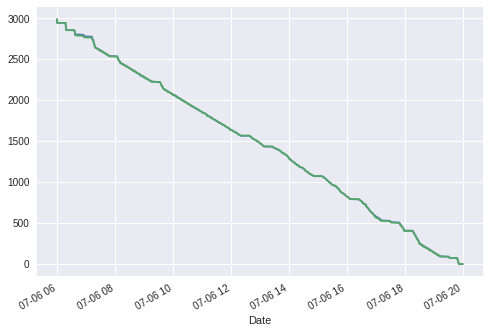

In [106]:
jour.budget.plot()
jour.budget_sans.plot()